In [2]:
#@title Area:

from requests import get
from json import dumps


ENDPOINT = "https://api.coronavirus.data.gov.uk/v1/data"
AREA_TYPE = "nation" #@param {type:"string"}

RELIABLE = 6

## If you want a different area, change this variable:
AREA_NAME = "england" #@param {type:"string"}

filters = [
    f"areaType={ AREA_TYPE }",
    f"areaName={ AREA_NAME }"
]

structure = {
    "date": "date",
    "name": "areaName",
    #"code": "areaCode",
    "cases": {
        "daily": "newCasesBySpecimenDate",
        "cumulative": "cumCasesBySpecimenDateRate"
        #"by age": "cumAdmissionsByAge"
    }
}

api_params = {
    "filters": str.join(";", filters),
    "structure": dumps(structure, separators=(",", ":"))
}


response = get(ENDPOINT, params=api_params, timeout=10)

if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')

output = response.json()

import matplotlib.pyplot as plt
import numpy as np

dates = []
cases_daily = []
cases_cum = []

for i in output['data']:
    dates.append(i['date'])
    cases_daily.append(i['cases']['daily'])
    cases_cum.append(i['cases']['cumulative'])

x = np.arange(len(dates))
dates = dates[::-1]
cases_daily = cases_daily[::-1]
cases_cum = cases_cum[::-1]

from scipy.stats import linregress

def regression(x, data):
  m, c = linregress(x, data)[:2]
  print(f'Best fit: y = {m:.3f} x + {c:.3f}')
  print(f'Average rate of new daily cases: {m:.3f}')
  return m*x + c

def plotter(x, data, n=0):
  if n > len(x):
    print('Not enough data')
    return None
  plt.scatter(x[-n-RELIABLE:], data[-n-RELIABLE:], color='purple')
  plt.plot(x[-n-RELIABLE:], regression(x[-n-RELIABLE:], data[-n-RELIABLE:]), 'r-')

def moving_avg(data, n):
  ma = [0 for _ in range(n-1)]
  for i in range(n, len(data)+1):
    avg = sum(data[i-n:i])/n
    ma.append(avg)
  return ma

Last reliable data point: 2020-09-18


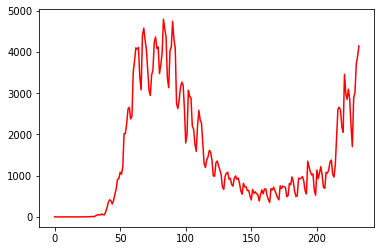

In [3]:
#@title Daily new cases:
#print(f'Latest date: {dates[-1]}')
#print(f'Latest # cases: {cases_daily[-1]}')
print(f'Last reliable data point: {dates[-RELIABLE]}')
plt.plot(x[:-RELIABLE+1], cases_daily[:-RELIABLE+1], 'r-')
#plt.plot(x, cases_daily, 'r-')
#print(dates[0])

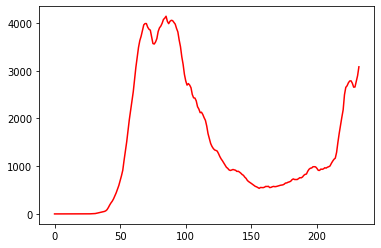

In [4]:
#@title n-day moving average of daily new cases:
n =  7#@param {type:"integer"}

ma = moving_avg(cases_daily, n)
plt.plot(x[:-RELIABLE+1], ma[:-RELIABLE+1], 'r-')

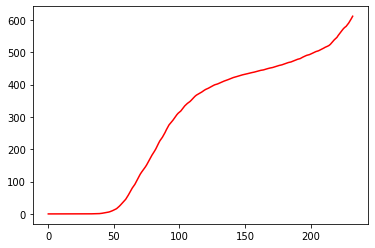

In [5]:
#@title Cumulative cases per 100k population:
plt.plot(x[:-RELIABLE+1], cases_cum[:-RELIABLE+1], 'r-')

Best fit: y = 92.262 x + -17900.684
Average rate of new daily cases: 92.262


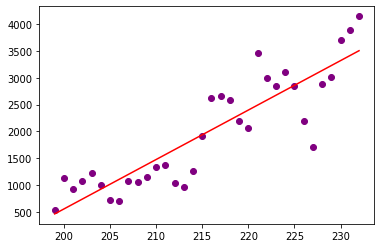

In [6]:
#@title Scatter plot for last n days of daily cases data:
n =  28#@param {type:"integer"}
plotter(x[:-RELIABLE+1], cases_daily[:-RELIABLE+1], n)
